In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# ===========================================
# Setup
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
T = 100      # sequence length
tau = 10     # lag
d_model = 64
n_heads = 2
batch_size = 128

In [4]:
n_beh, n_neu = 1, 6

In [5]:
import torch

def generate_batch(batch_size, T, tau, obs_noise=0.0):

    beh = torch.randn(batch_size, T)
    neu = torch.zeros(batch_size, T, n_neu)

    # Fixed neuron weights shared across the batch
    #W_fwd = torch.zeros(n_neu)
    #W_bwd = torch.zeros(n_neu)

    # Each neuron gets a convex combination (weights sum to 1)
    W_fwd = torch.rand(n_neu)
    W_bwd = 1.0 - W_fwd

    for i in range(batch_size):
        beh_forward  = torch.roll(beh[i], shifts=+tau)
        beh_backward = torch.roll(beh[i], shifts=-tau)

        # Stationary mixture across all neurons
        neu[i] = (W_fwd * beh_forward[:, None] +
                  W_bwd * beh_backward[:, None])

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)

    return beh.unsqueeze(-1), neu

In [6]:
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)

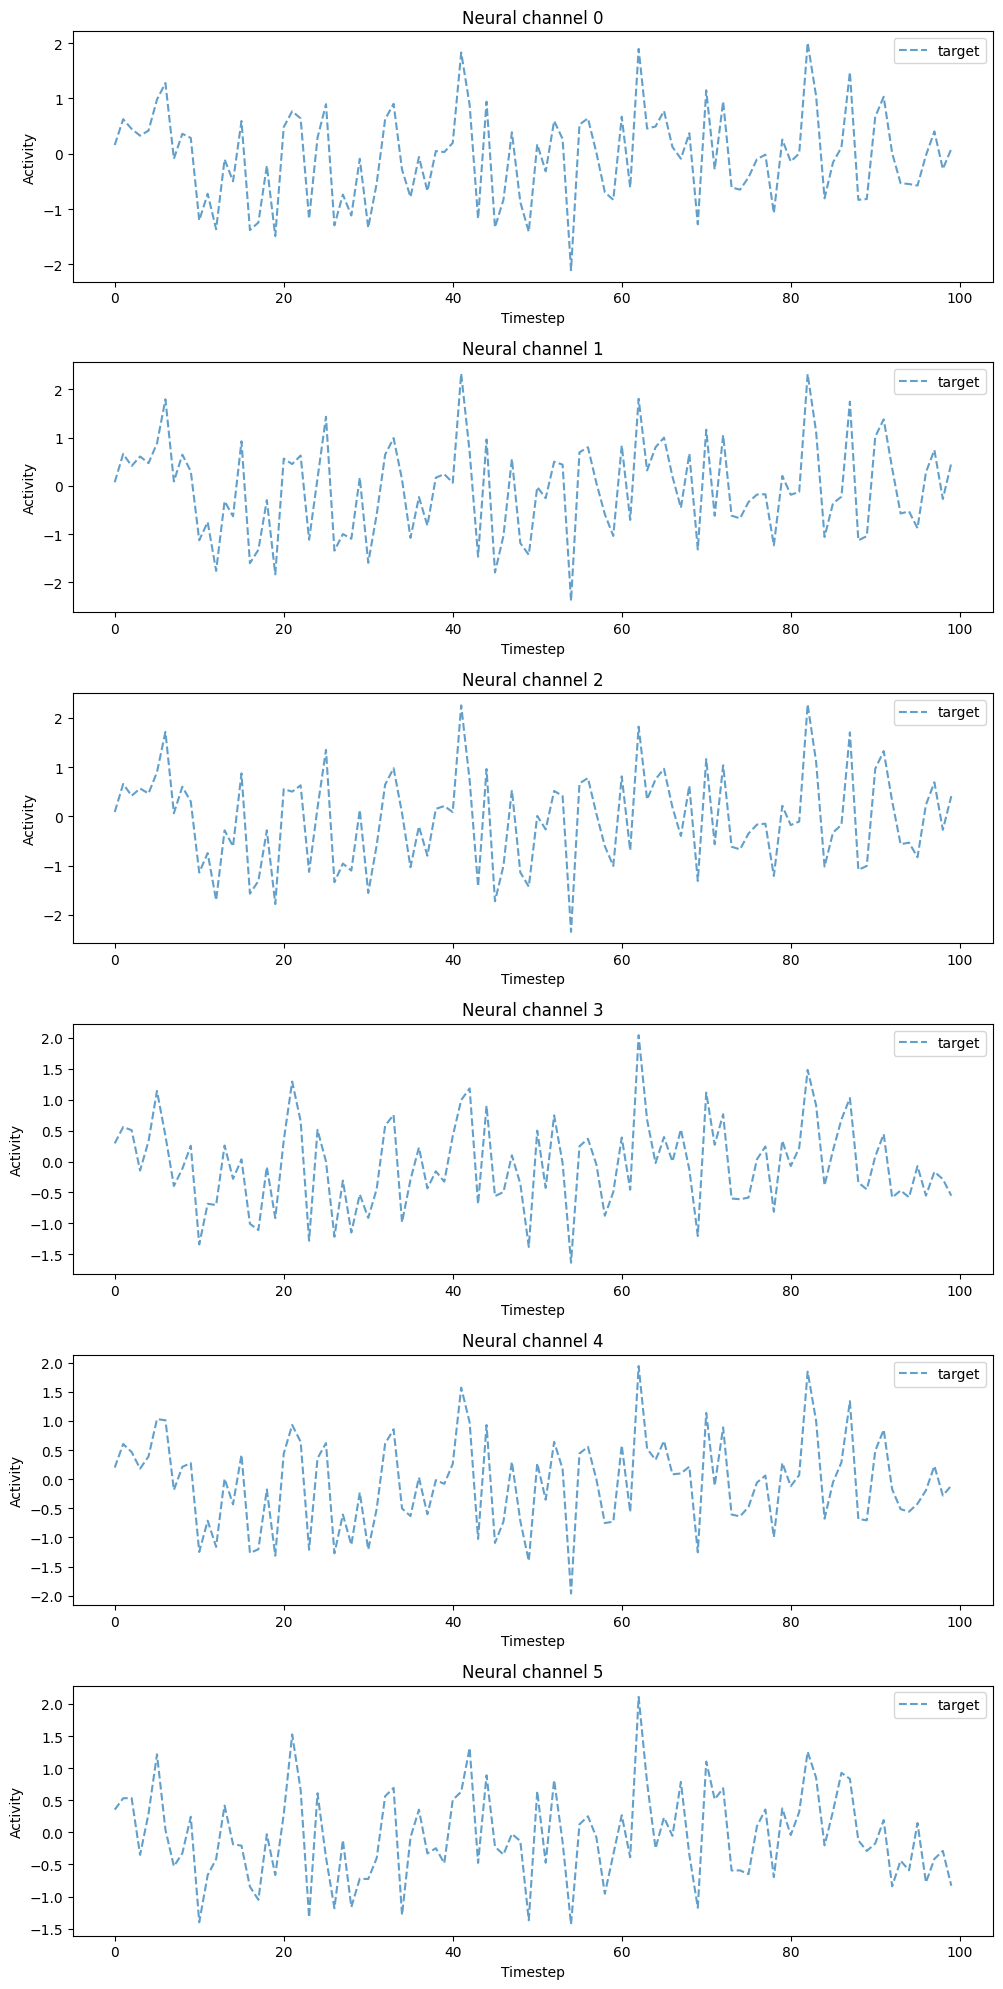

In [7]:
b = 0  # sample index
plt.figure(figsize=(10,20))
for c in range(neu_test.shape[-1]):
    plt.subplot(n_neu,1,c+1)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# ===========================================
# Positional Encoding
# ===========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncoding(d_model).to(device)

In [9]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class BiXLagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(n_beh, d_model)
        self.in_proj_neu = nn.Linear(n_neu, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.reduce_dim = 1  # or whatever latent dimension you want
        self.attn_out_causal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.attn_out_acausal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.out_neu_proj = nn.Linear(2*self.reduce_dim, n_neu)  # predict neural channels
        self.out_beh_proj = nn.Linear(2*self.reduce_dim, n_beh)  # predict behavior

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        B, T_dec, _ = y_emb.shape
        T_enc = x_emb.shape[1]
        device = y_emb.device

        # ------------------------------------------------
        # Build attention masks
        # ------------------------------------------------
        mask_causal = torch.triu(torch.ones(T_dec, T_enc, device=device), diagonal=1).bool()
        mask_acausal = torch.tril(torch.ones(T_dec, T_enc, device=device), diagonal=-1).bool()

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_causal,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_acausal,
            need_weights=True,
            average_attn_weights=False
        )

        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension
        # 🔻 Reduce to a lower-dimensional latent subspace
        z_causal = self.attn_out_causal_proj(out_causal)
        z_acausal = self.attn_out_causal_proj(out_acausal)

        # Concatenate outputs and attention weights
        z_out = torch.cat([z_causal, z_acausal], dim=-1)

        out_neu = self.out_neu_proj(z_out)
        out_beh = self.out_beh_proj(z_out)

        return out_neu, out_beh, attn_weights, z_out

In [10]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class LagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(n_beh, d_model)
        self.in_proj_neu = nn.Linear(n_neu, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.reduce_dim = 1  # or whatever latent dimension you want
        self.attn_out_causal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.attn_out_acausal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.out_neu_proj = nn.Linear(2*self.reduce_dim, n_neu)  # predict neural channels
        self.out_beh_proj = nn.Linear(2*self.reduce_dim, n_beh)  # predict behavior

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension
        # 🔻 Reduce to a lower-dimensional latent subspace
        z_causal = self.attn_out_causal_proj(out_causal)
        z_acausal = self.attn_out_causal_proj(out_acausal)

        # Concatenate outputs and attention weights
        z_out = torch.cat([z_causal, z_acausal], dim=-1)

        out_neu = self.out_neu_proj(z_out)
        out_beh = self.out_beh_proj(z_out)

        return out_neu, out_beh, attn_weights, z_out

In [11]:
n_steps = 2000

In [31]:
# instantiate / train as usual
model = BiXLagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.408369
Step 1000/2000, Loss: 0.298847
Step 1500/2000, Loss: 0.151324
Step 2000/2000, Loss: 0.276344


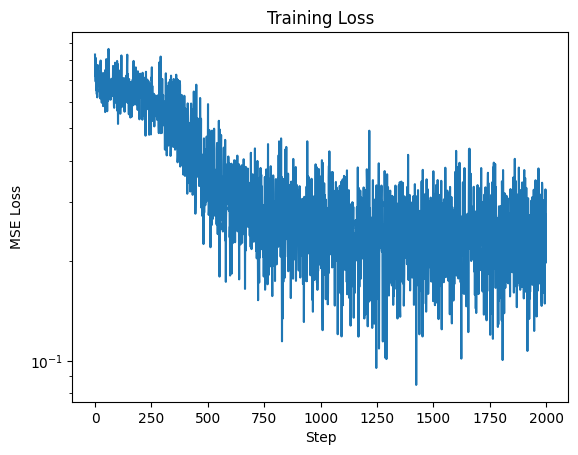

In [32]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [33]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

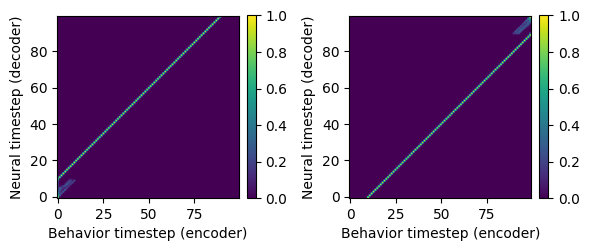

In [34]:
import math
import matplotlib.pyplot as plt

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

# Each subplot 3x3 inches → square layout
plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    ax = plt.subplot(rows, cols, h + 1)
    im = ax.imshow(attn_map, aspect='equal', origin='lower', cmap='viridis')  # <- square cells
    ax.set_xlabel("Behavior timestep (encoder)")
    ax.set_ylabel("Neural timestep (decoder)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("heads_BiX_square_CC.png", dpi=300, bbox_inches='tight')
plt.show()

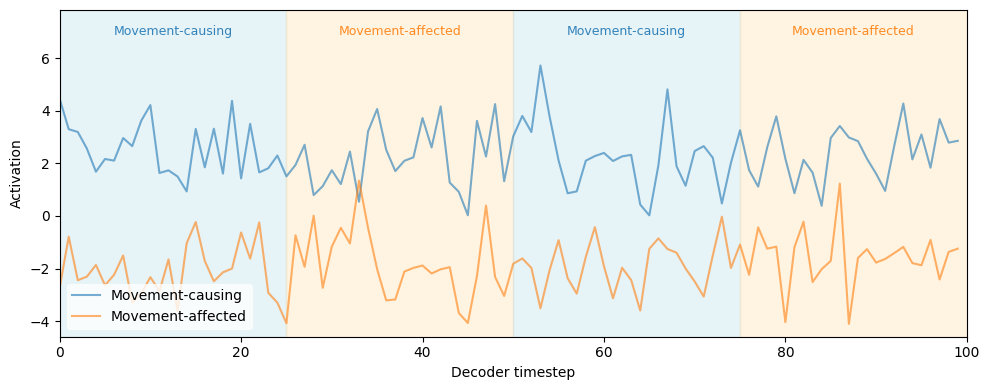

In [35]:
import matplotlib.pyplot as plt
import torch

seg_len = 25  # match your generator

B, T, D2 = z_out.shape
D = D2 // 2
b = 1
causal_out = z_out[0, :, :D].detach().cpu()
acausal_out = z_out[0, :, D:].detach().cpu()

fig, ax = plt.subplots(figsize=(10, 4))

# --- Shaded background for alternating causal/acausal periods ---
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# --- Plot latent components ---
for d in range(D):
    ax.plot(causal_out[:, d], color='tab:blue', alpha=0.6,
            label='Movement-causing' if d == 0 else "")
for d in range(D):
    ax.plot(acausal_out[:, d], color='tab:orange', alpha=0.6,
            label='Movement-affected' if d == 0 else "")

# --- Labels, limits, etc. ---
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Activation")
ax.set_xlim(0, T)

# --- Add top text labels for shaded regions ---
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05  # place slightly above top of data

for s in range(0, T, seg_len):
    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

# Extend y-limits to make room for the top text
ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# --- Move legend to bottom-left (away from text) ---
leg = ax.legend(loc='lower left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.show()
#plt.savefig("latent_components_BiX.png", dpi=300, bbox_inches='tight')

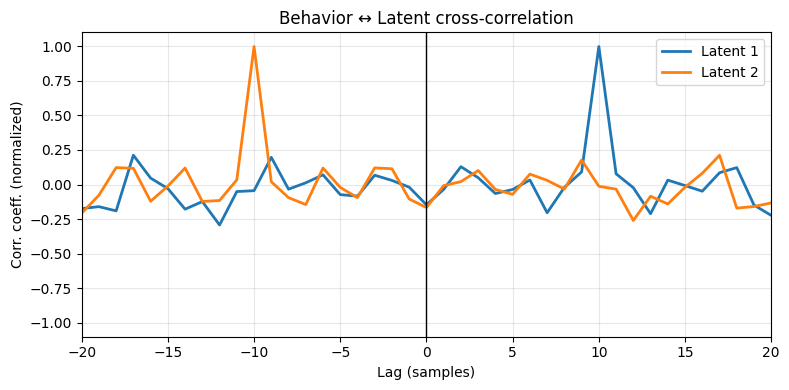

<Figure size 640x480 with 0 Axes>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- params ----
max_lag_req = 100

# ---- shapes ----
B, T, D2 = z_out.shape
D = D2 // 2

# clamp lags so we never index empty windows
max_lag = int(min(max_lag_req, T - 2))
lags = np.arange(-max_lag, max_lag + 1)

# accumulators: [B, D, n_lags]
corr_causal = np.full((B, D, len(lags)), np.nan, dtype=np.float64)
corr_acausal = np.full((B, D, len(lags)), np.nan, dtype=np.float64)

for b in range(B):
    behavior = beh_test[b, :, 0].detach().cpu().numpy().astype(np.float64)
    Zc = z_out[b, :, :D].detach().cpu().numpy().astype(np.float64)   # causal
    Za = z_out[b, :, D:].detach().cpu().numpy().astype(np.float64)   # acausal

    # (optional) global standardization improves numeric stability
    behavior = (behavior - behavior.mean()) / (behavior.std() + 1e-8)
    Zc = (Zc - Zc.mean(axis=0, keepdims=True)) / (Zc.std(axis=0, keepdims=True) + 1e-8)
    Za = (Za - Za.mean(axis=0, keepdims=True)) / (Za.std(axis=0, keepdims=True) + 1e-8)

    for d in range(D):
        for i, lag in enumerate(lags):
            if lag >= 0:
                x_c = Zc[lag:, d]
                x_a = Za[lag:, d]
                y   = behavior[:T - lag]
            else:
                L = T + lag  # lag < 0
                x_c = Zc[:L, d]
                x_a = Za[:L, d]
                y   = behavior[-lag:]  # shift behavior forward to align

            # defend against tiny/empty overlaps
            if x_c.size < 2 or y.size < 2: 
                continue

            # compute correlation coefficient at this lag
            def r_xy(x, y):
                xm = x - x.mean()
                ym = y - y.mean()
                denom = (xm.std() * ym.std()) + 1e-12
                return float((xm @ ym) / (len(xm) * denom))

            corr_causal[b, d, i]  = r_xy(x_c, y)
            corr_acausal[b, d, i] = r_xy(x_a, y)

# batch + dim average, ignoring NaNs from invalid edges
mean_causal  = np.nanmean(corr_causal, axis=(0, 1))
mean_acausal = np.nanmean(corr_acausal, axis=(0, 1))
std_causal   = np.nanstd(corr_causal,  axis=(0, 1))
std_acausal  = np.nanstd(corr_acausal, axis=(0, 1))

# normalize both curves to same scale for plotting (optional)
scale = max(np.nanmax(np.abs(mean_causal)), np.nanmax(np.abs(mean_acausal)), 1e-8)
mean_causal  = mean_causal  / scale
mean_acausal = mean_acausal / scale
std_causal   = std_causal   / scale
std_acausal  = std_acausal  / scale

# ---- plot ----
plt.figure(figsize=(8, 4))
plt.plot(lags, mean_causal, color="tab:blue", lw=2, label="Latent 1")
plt.fill_between(lags, mean_causal - std_causal, mean_causal + std_causal,
                 color="tab:blue", alpha=0.2, linewidth=0)
plt.plot(lags, mean_acausal, color="tab:orange", lw=2, label="Latent 2")
plt.fill_between(lags, mean_acausal - std_acausal, mean_acausal + std_acausal,
                 color="tab:orange", alpha=0.2, linewidth=0)

plt.axvline(0, color="k", lw=1)
plt.xlabel("Lag (samples)")
plt.ylabel("Corr. coeff. (normalized)")
plt.title("Behavior ↔ Latent cross-correlation")
plt.legend()
plt.xlim(-20,20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("CC_BiX.png", dpi=300, bbox_inches='tight')

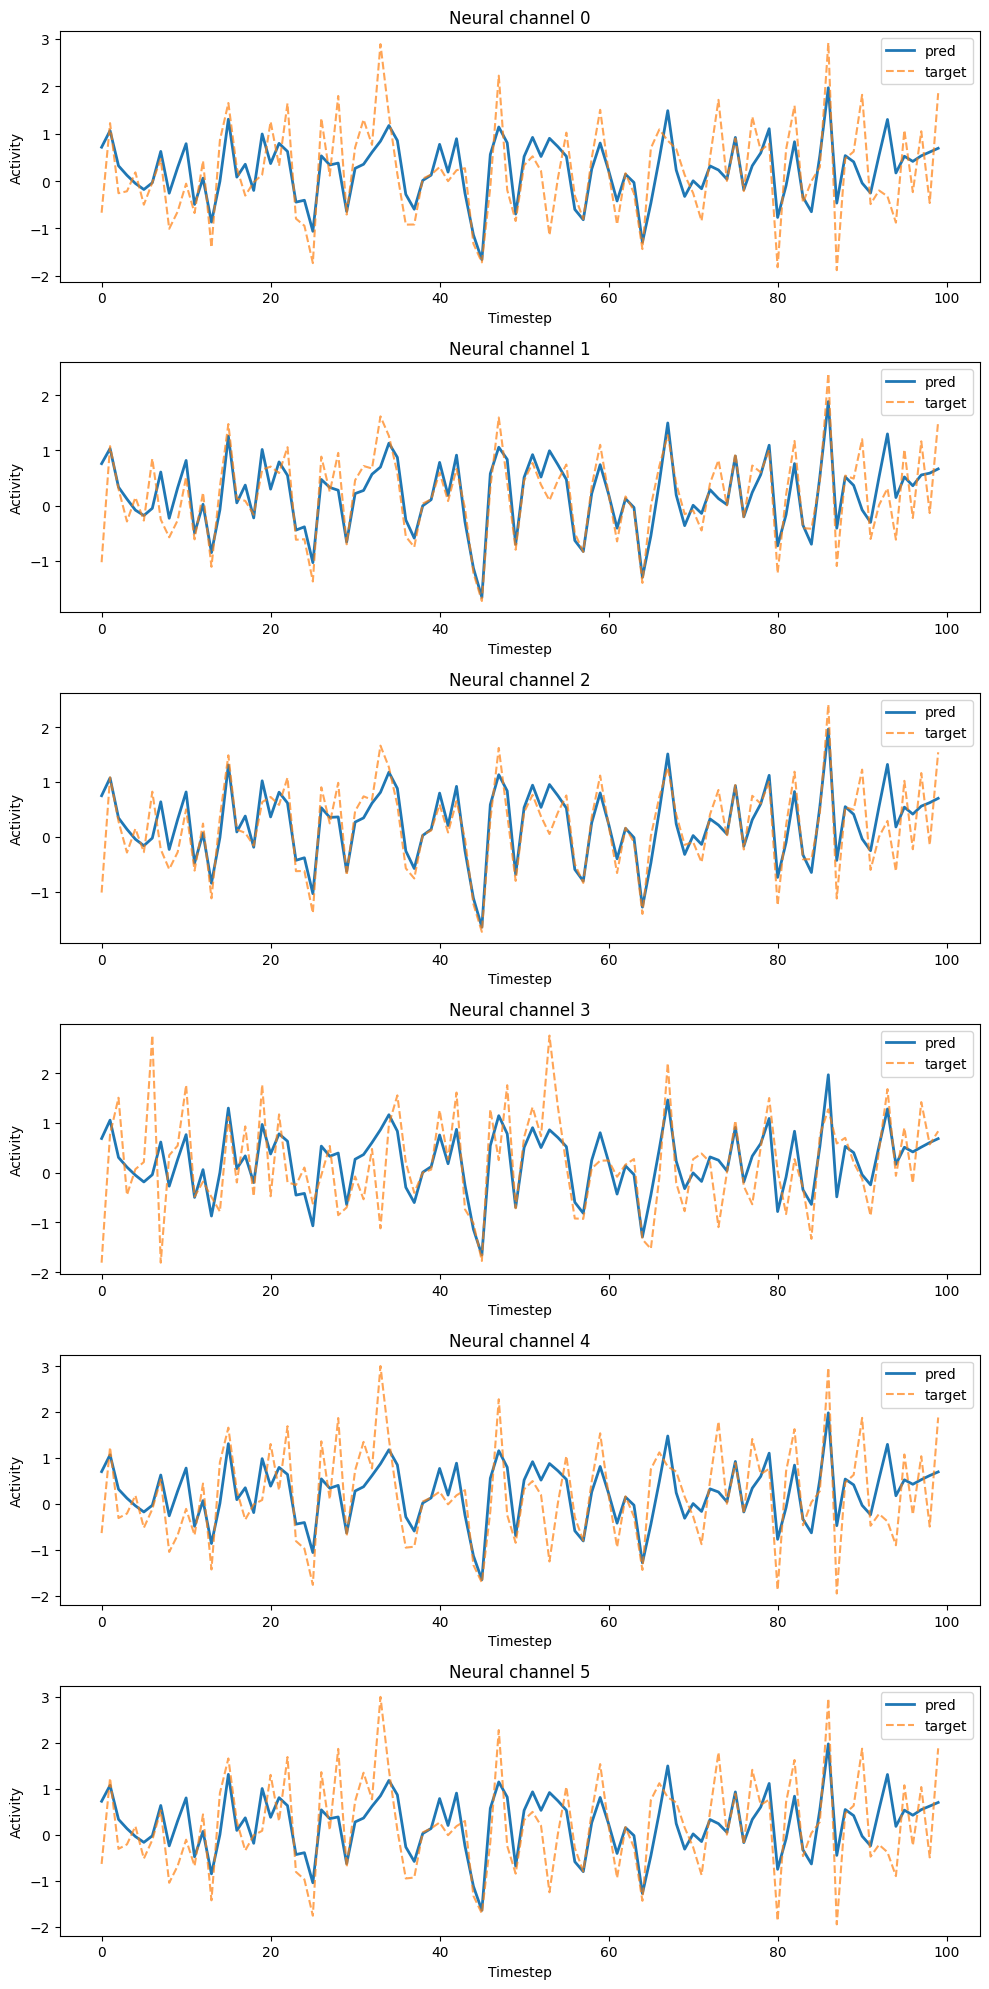

In [37]:
b = 0  # sample index
plt.figure(figsize=(10,20))
for c in range(neu_pred.shape[-1]):
    plt.subplot(n_neu,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

## No seperation

In [19]:
# instantiate / train as usual
model = LagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.313507
Step 1000/2000, Loss: 0.145602
Step 1500/2000, Loss: 0.115239
Step 2000/2000, Loss: 0.169935


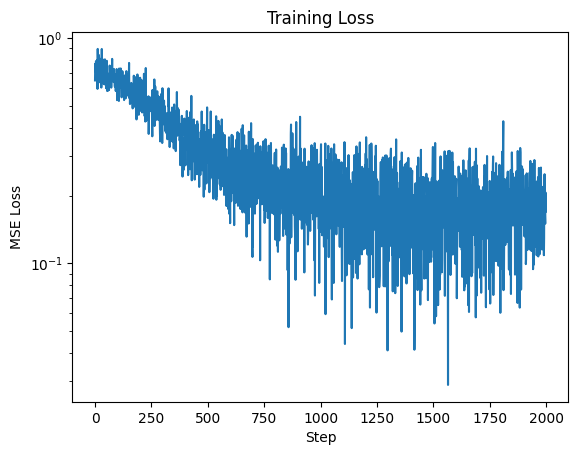

In [20]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [21]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

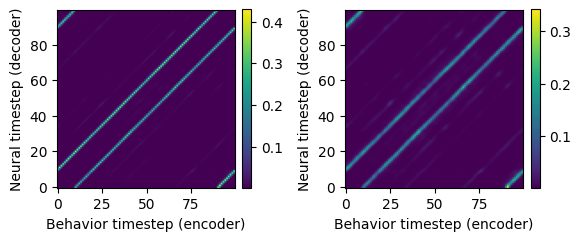

In [29]:
import math
import matplotlib.pyplot as plt

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

# Each subplot 3x3 inches → square layout
plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    ax = plt.subplot(rows, cols, h + 1)
    im = ax.imshow(attn_map, aspect='equal', origin='lower', cmap='viridis')  # <- square cells
    ax.set_xlabel("Behavior timestep (encoder)")
    ax.set_ylabel("Neural timestep (decoder)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("heads_square_CC.png", dpi=300, bbox_inches='tight')
plt.show()

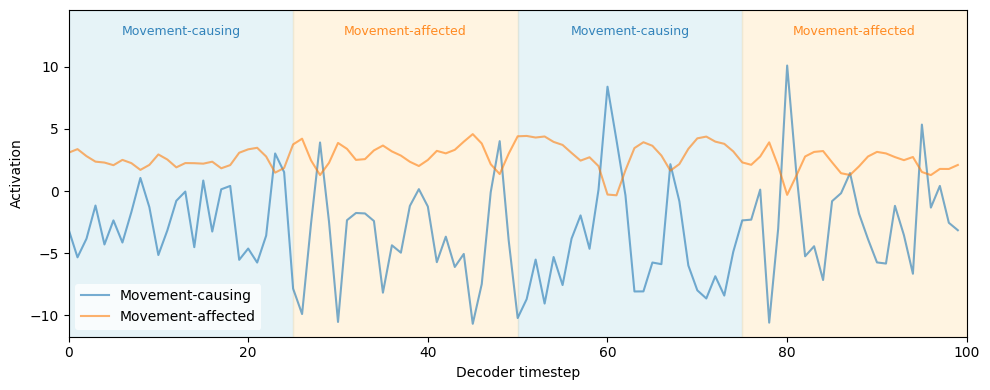

In [23]:
import matplotlib.pyplot as plt
import torch

seg_len = 25  # match your generator

B, T, D2 = z_out.shape
D = D2 // 2
causal_out = z_out[0, :, :D].detach().cpu()
acausal_out = z_out[0, :, D:].detach().cpu()

fig, ax = plt.subplots(figsize=(10, 4))

# --- Shaded background for alternating causal/acausal periods ---
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# --- Plot latent components ---
for d in range(D):
    ax.plot(causal_out[:, d], color='tab:blue', alpha=0.6,
            label='Movement-causing' if d == 0 else "")
for d in range(D):
    ax.plot(acausal_out[:, d], color='tab:orange', alpha=0.6,
            label='Movement-affected' if d == 0 else "")

# --- Labels, limits, etc. ---
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Activation")
ax.set_xlim(0, T)

# --- Add top text labels for shaded regions ---
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05  # place slightly above top of data

for s in range(0, T, seg_len):
    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

# Extend y-limits to make room for the top text
ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# --- Move legend to bottom-left (away from text) ---
leg = ax.legend(loc='lower left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.show()
#plt.savefig("factors.png", dpi=300, bbox_inches='tight')

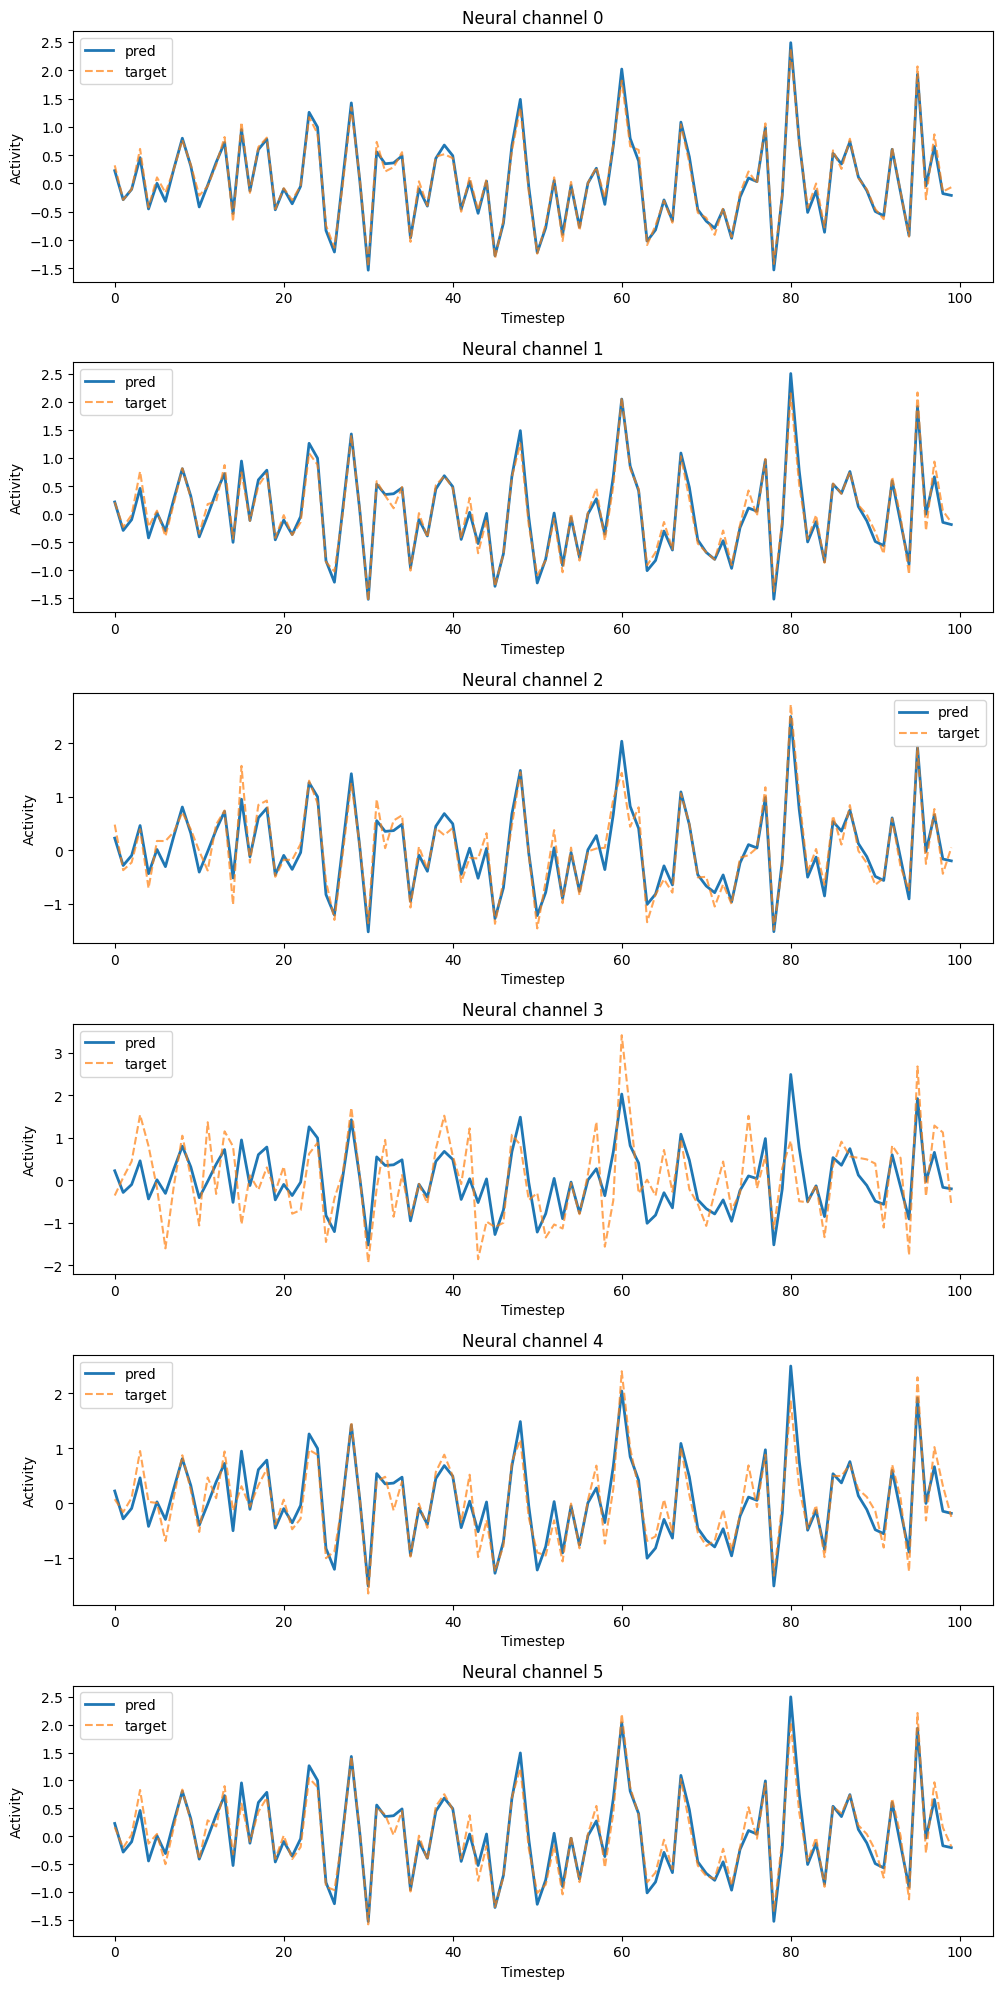

In [24]:
b = 0  # sample index
plt.figure(figsize=(10,20))
for c in range(neu_pred.shape[-1]):
    plt.subplot(n_neu,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

In [25]:
beh.shape

torch.Size([128, 100, 1])

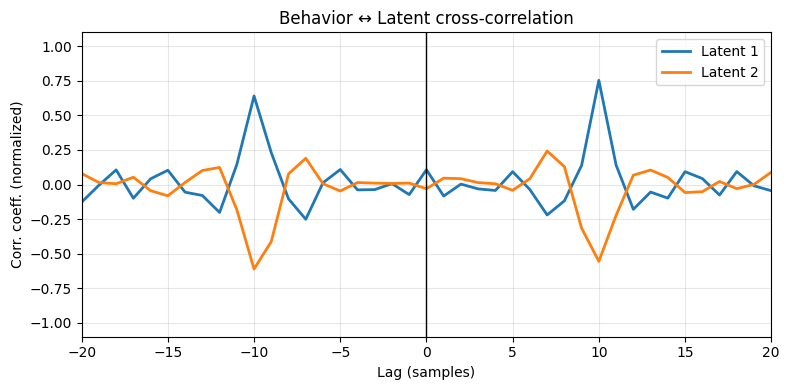

<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- params ----
max_lag_req = 100

# ---- shapes ----
B, T, D2 = z_out.shape
D = D2 // 2

# clamp lags so we never index empty windows
max_lag = int(min(max_lag_req, T - 2))
lags = np.arange(-max_lag, max_lag + 1)

# accumulators: [B, D, n_lags]
corr_causal = np.full((B, D, len(lags)), np.nan, dtype=np.float64)
corr_acausal = np.full((B, D, len(lags)), np.nan, dtype=np.float64)

for b in range(B):
    behavior = beh_test[b, :, 0].detach().cpu().numpy().astype(np.float64)
    Zc = z_out[b, :, :D].detach().cpu().numpy().astype(np.float64)   # causal
    Za = z_out[b, :, D:].detach().cpu().numpy().astype(np.float64)   # acausal

    # (optional) global standardization improves numeric stability
    behavior = (behavior - behavior.mean()) / (behavior.std() + 1e-8)
    Zc = (Zc - Zc.mean(axis=0, keepdims=True)) / (Zc.std(axis=0, keepdims=True) + 1e-8)
    Za = (Za - Za.mean(axis=0, keepdims=True)) / (Za.std(axis=0, keepdims=True) + 1e-8)

    for d in range(D):
        for i, lag in enumerate(lags):
            if lag >= 0:
                x_c = Zc[lag:, d]
                x_a = Za[lag:, d]
                y   = behavior[:T - lag]
            else:
                L = T + lag  # lag < 0
                x_c = Zc[:L, d]
                x_a = Za[:L, d]
                y   = behavior[-lag:]  # shift behavior forward to align

            # defend against tiny/empty overlaps
            if x_c.size < 2 or y.size < 2: 
                continue

            # compute correlation coefficient at this lag
            def r_xy(x, y):
                xm = x - x.mean()
                ym = y - y.mean()
                denom = (xm.std() * ym.std()) + 1e-12
                return float((xm @ ym) / (len(xm) * denom))

            corr_causal[b, d, i]  = r_xy(x_c, y)
            corr_acausal[b, d, i] = r_xy(x_a, y)

# batch + dim average, ignoring NaNs from invalid edges
mean_causal  = np.nanmean(corr_causal, axis=(0, 1))
mean_acausal = np.nanmean(corr_acausal, axis=(0, 1))
std_causal   = np.nanstd(corr_causal,  axis=(0, 1))
std_acausal  = np.nanstd(corr_acausal, axis=(0, 1))

# normalize both curves to same scale for plotting (optional)
scale = max(np.nanmax(np.abs(mean_causal)), np.nanmax(np.abs(mean_acausal)), 1e-8)
mean_causal  = mean_causal  / scale
mean_acausal = mean_acausal / scale
std_causal   = std_causal   / scale
std_acausal  = std_acausal  / scale

# ---- plot ----
plt.figure(figsize=(8, 4))
plt.plot(lags, mean_causal, color="tab:blue", lw=2, label="Latent 1")
plt.fill_between(lags, mean_causal - std_causal, mean_causal + std_causal,
                 color="tab:blue", alpha=0.2, linewidth=0)
plt.plot(lags, mean_acausal, color="tab:orange", lw=2, label="Latent 2")
plt.fill_between(lags, mean_acausal - std_acausal, mean_acausal + std_acausal,
                 color="tab:orange", alpha=0.2, linewidth=0)

plt.axvline(0, color="k", lw=1)
plt.xlabel("Lag (samples)")
plt.ylabel("Corr. coeff. (normalized)")
plt.title("Behavior ↔ Latent cross-correlation")
plt.legend()
plt.xlim(-20,20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("CC.png", dpi=300, bbox_inches='tight')

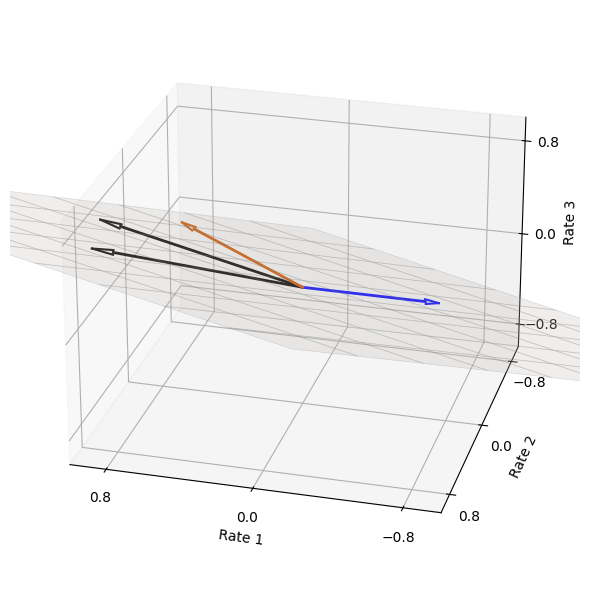

<Figure size 640x480 with 0 Axes>

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper to rotate plane toward viewer (around x-axis) ---
def rotate_x(vec, angle_deg):
    """Rotate a 3D vector around the x-axis by given angle in degrees."""
    a = np.deg2rad(angle_deg)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a), np.cos(a)]
    ])
    return Rx @ vec

# --- Plane setup (rotated toward viewer) ---
tilt_angle = -20  # negative = tilt plane downward toward viewer
v1p = rotate_x(np.array([1, 0, 0.5]), tilt_angle)
v2p = rotate_x(np.array([0.95, 0.35, 0.5]), tilt_angle)
B = np.column_stack([v1p, v2p])

# --- Gray (reference) basis ---
psi = np.deg2rad(65)
u1b_2d = np.array([1.0, 0.0])
u2b_2d = np.array([np.cos(psi), np.sin(psi)])
b1 = B @ u1b_2d
b2 = B @ u2b_2d

# --- Black basis = Gray rotated 90° clockwise within plane ---
Rcw90 = np.array([[0, 1], [-1, 0]])
u1r_2d = Rcw90 @ u1b_2d
u2r_2d = Rcw90 @ u2b_2d
r1 = B @ u1r_2d
r2 = B @ u2r_2d

# --- Normalize and scale lengths ---
def normalize(v): 
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

scale_b, scale_r = 1.2, 0.8
b1, b2, r1, r2 = [normalize(v)*s for v, s in zip([b1, b2, r1, r2], [scale_b, scale_b, scale_r, scale_r])]

# --- Plane grid (sparser) ---
s = np.linspace(-1.5, 1.5, 10)
t = np.linspace(-1.5, 1.5, 10)
S, T = np.meshgrid(s, t)
pts = (B @ np.vstack([S.flatten(), T.flatten()])).T
X, Y, Z = pts[:, 0].reshape(S.shape), pts[:, 1].reshape(S.shape), pts[:, 2].reshape(S.shape)

# --- Helper to draw open arrows ---
def draw_arrow(ax, start, vec, color, head_frac=0.1, head_width=0.02):
    end = start + vec
    shaft = np.vstack([start, end - head_frac * vec])
    ax.plot(shaft[:, 0], shaft[:, 1], shaft[:, 2], color=color, lw=2)

    v_dir = normalize(vec)
    normal = np.cross(v1p, v2p)
    normal /= np.linalg.norm(normal)
    perp = np.cross(normal, v_dir)
    p1 = end - head_frac * vec + head_width * perp
    p2 = end - head_frac * vec - head_width * perp
    ax.plot([p1[0], end[0]], [p1[1], end[1]], [p1[2], end[2]], color=color, lw=1.5)
    ax.plot([p2[0], end[0]], [p2[1], end[1]], [p2[2], end[2]], color=color, lw=1.5)

# --- Plot ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# More visible plane (darker tone, thicker edges, higher alpha)
ax.plot_surface(X, Y, Z, color=(0.95, 0.93, 0.9), alpha=0.25, linewidth=.5, edgecolor="grey")

# Draw both bases (flat on plane)
for vec in [b1, b2]:
    draw_arrow(ax, np.zeros(3), vec, color='black')

draw_arrow(ax, np.zeros(3), r1, color='blue')
draw_arrow(ax, np.zeros(3), r2, color='#cc5500')

# --- Labels and view ---
ax.set_xlabel("Rate 1")
ax.set_ylabel("Rate 2")
ax.set_zlabel("Rate 3")

# Keep camera fixed — do NOT rotate view
ax.view_init(elev=25, azim=105)

# Equal box aspect and fixed limits
ax.set_box_aspect([1, 1, 0.7])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Fewer tick marks for clarity
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(3))

ax.set_title("")
plt.tight_layout()
plt.show()
plt.savefig("space.png", dpi=300, bbox_inches='tight')
